In [2]:
# Import Julia packages
using DrWatson
@quickactivate
using Revise
using LinearAlgebra
using DelimitedFiles
using SparseArrays
using StaticArrays
using BlockArrays
using CairoMakie
using UnPack
using FromFile
using GeometryBasics
using Random
using Colors
using JLD2
using LaTeXStrings
using Glob
using Printf
using Arpack
using ColorSchemes
using NumericIO

@from "$(projectdir())/src/VertexModelContainers.jl" using VertexModelContainers
@from "$(projectdir())/src/Laplacians.jl" using Laplacians
@from "$(projectdir())/src/AnalysisFunctions.jl" using AnalysisFunctions
@from "$(projectdir())/src/CellProperties.jl" using CellProperties

In [223]:
import Pkg; Pkg.add("NumericIO")

    Updating registry at `C:\Users\v35431nc\.julia\registries\General.toml`


   Resolving package versions...

   Installed NumericIO ─ v0.3.2


    Updating `C:\Users\v35431nc\Documents\VM_code\VertexModel\Project.toml`


  [6c575b1c] + NumericIO v0.3.2
    Updating `C:\Users\v35431nc\Documents\VM_code\VertexModel\Manifest.toml`


  [6c575b1c] + NumericIO v0.3.2


Precompiling

 project...

  ✓ 

NumericIO

  ✓ VertexModel


  2 dependencies successfully precompiled in 250 seconds. 423 already precompiled.


In [36]:
f=Glob.glob("Reference_cells/*L₀*","C:\\Users\\v35431nc\\Documents\\VM_code\\VertexModel\\data\\sims" )[2]
@unpack R, matrices, params = load(datadir(f,"frameData","systemData067.jld2"))
@unpack nCells,nVerts, γ, L₀ = params
@unpack cellAreas,cellPerimeters, cellTensions, cellPressures, edgeTangents,A,Ā,B,B̄,C, ϵ = matrices
mkpath(datadir(f,"paper_figures"))

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


"C:\\Users\\v35431nc\\Documents\\VM_code\\VertexModel\\data\\sims\\Reference_cells\\L₀=0.75_realTimetMax=4.32e6_t1Threshold=0.05_γ=0.2_23-11-21-11-55-24\\paper_figures"

In [37]:
G=makeG(params)

E=makeE(matrices,params)
Eflat=kron(E,Matrix(1.0I, 2, 2))

M=makeM(matrices)
Mflat=transpose(reshape(reinterpret(Float64,[vcat(Matrix(M)[x,:]...) for x in collect(1:2*nCells)]), ( 2*nVerts, 2*nCells)))

Lv=makeEvLv(M, G)
Lc=makeEvLc(M)

X=makeX(params, matrices)
g=vcat(cellPressures, -cellTensions)

gX=Matrix{SMatrix{2,2,Float64,4}}(undef,nVerts,nVerts)
fill!(gX,@SMatrix zeros(2,2))

for α=1:2*nCells
    gX+=g[α]X[α, :,:]
end

In [38]:
LcE=Matrix(tr.(M*(inv(E)*M'))*G)
evalLc,evecLctemp=LAPACK.syev!('V','U',deepcopy(sqrt(G)*Matrix(LcE)*inv(sqrt(G))))
evecLc=inv(sqrt(G))*evecLctemp

LvE=inv(E)*Lv
evalLv,evecLvtemp=LAPACK.syev!('V','U',deepcopy(sqrt(Eflat)*Matrix(mortar(LvE))*inv(sqrt(Eflat))))
evecLv=inv(sqrt(Eflat))*evecLvtemp

H=Matrix(mortar(LvE)).+Matrix(mortar(inv(E)*gX))
evalH,evecHtemp=LAPACK.syev!('V','U',deepcopy(sqrt(Eflat)*H*inv(sqrt(Eflat))))
evecH=inv(sqrt(Eflat))*evecHtemp

Ntemp=Matrix(sqrt.(G)*M*inv(sqrt.(E)))
Ntempflat=transpose(reshape(reinterpret(Float64,[vcat(Matrix(Ntemp)[x,:]...) for x in collect(1:2*nCells)]), ( 2*nVerts, 2*nCells)))
UNF,sNF,VNF=svd(Ntempflat, full=true)

Y=inv(sqrt.(G))*UNF
Z=inv(sqrt.(Eflat))*VNF

D=evecLv'*Matrix(mortar(gX))*evecLv
DD=D + Diagonal(evalLv)
evalDD,evecDD=LAPACK.syev!('V','U',deepcopy(DD))
#evecDD=inv(sqrt(Eflat))*qr(sqrt(Eflat)*evecDDtemp).Q

evecmap=[evecDD[:,x]'*(evecLv'*Matrix(mortar(gX))*evecLv+Diagonal(evalLv))*evecDD[:,x] for x in 1:2nVerts]
evmapLv=[evecDD[:,x]'*(Diagonal(evalLv))*evecDD[:,x] for x in 1:2nVerts]
evmapgX=[evecDD[:,x]'*(evecLv'*Matrix(mortar(gX))*evecLv)*evecDD[:,x] for x in 1:2nVerts]



396-element Vector{Float64}:
  -6.409407022080682e-8
  -4.3091799694037185e-15
   5.734605121326789e-15
   0.23296844998046215
   0.35491203175140856
   1.0393964279199792
   0.8857396273279686
   1.1453545164838037
   1.7644698883842238
   1.918982147744584
   ⋮
 303.98149191839184
 313.3031682639927
 318.3604577454199
 330.0625952349681
 332.2400667769136
 370.4193895603693
 369.12007232278745
 486.9102165197648
 494.5615349057478

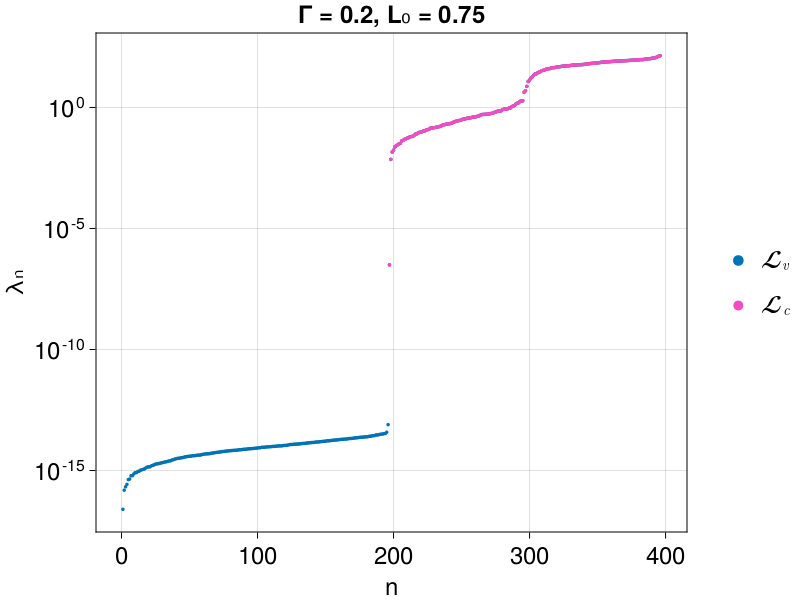

In [72]:
nv=LinRange(1, 2*nVerts, 2*nVerts)
nc=LinRange(2*nVerts-2*nCells+1, 2*nVerts, 2*nCells)
nc2=LinRange(1, 2*nCells, 2*nCells)
nD=LinRange(2*nVerts-2*nCells, 2*nVerts, 2*nCells-1)
fig = Figure(fontsize=24)
ax=Axis(fig[1, 1], xlabel="n", ylabel="λₙ", title="Γ = "*string(params.γ)*", L₀ = "*string(params.L₀), yscale=log10)

#scatter!(ax,nv, sort(abs.(evalH)), color=:black,markersize=4, label=L"\lambda_n,\quad \mathcal{H}")
scatter!(ax,nv, sort(abs.(evalLv)), color=ColorSchemes.seaborn_colorblind6[1],markersize=5, label=L"\mathcal{L}_v")
scatter!(ax,nc, sort(abs.(evalLc)), color=ColorSchemes.seaborn_bright[7],markersize=5, label=L"\mathcal{L}_c")
#scatter!(ax,nc, log10.((abs.(evalLc))), color=:red,markersize=4, label=L"\lambda_n,\quad \mathcal{L}_v^G")


#scatter!(ax,nv, (log10.((abs.([evecDD[:,x]'*Eflat*(evecLv'*Matrix(mortar(gX))*evecLv)*evecDD[:,x] for x in 1:2nVerts])))), color=:orange,markersize=4, label="qₙᵀE⋅(Zᵀ⋅gᵀX⋅Z)⋅qₙ")#
#scatter!(ax,nv, (log10.((abs.([evecDD[:,x]'*Eflat*(Diagonal(vcat(zeros(2*nVerts-2*nCells),reverse(sNF.^2))))*evecDD[:,x] for x in 1:2nVerts])))), color=:green,markersize=4, label="qₙᵀE⋅(Σ²)⋅qₙ")#
#scatter!(ax,nv, (log10.((abs.([evecDDs[:,x]'*Eflat*(Z[:, end:-1:1]'*Matrix(mortar(gX))*Z[:, end:-1:1])*evecDDs[:,x] for x in 1:2nVerts])))), color=:orange,markersize=4, label="qₙᵀE⋅(Zᵀ⋅gᵀX⋅Z)⋅qₙ")#
#scatter!(ax,nv, (log10.((abs.([evecDDs[:,x]'*Eflat*(Diagonal(vcat( zeros(2*nVerts-2*nCells),reverse(sNF.^2))))*evecDDs[:,x] for x in 1:2nVerts])))), color=:green,markersize=4, label="qₙᵀE⋅(Σ²)⋅qₙ")#

#scatter!(ax,nv, (log10.(sort(abs.(evecmap)))), color=:orange,markersize=4, label="λₙ, D+diag(σ²ₙ)")#
#scatter!(ax,nv[1:2*nVerts-2*nCells], (log10.((abs.(evecmap)[1:2*nVerts-2*nCells]))), color=:green,markersize=4, label="ZₙE.gX.Zₙ")
#scatter!(ax,nc,log10.(reverse(sMH.^2)), color=:pink,markersize=4, label="σ²ₙ, MH")#


#scatter!(ax,nv[1:2*nVerts-2*nCells], (log10.((abs.(testLv[1:2*nVerts-2*nCells])))), color=:green,markersize=4, label="ZₙE.gX.Zₙ")
#scatter!(ax,nv[2*nVerts+1-2*nCells:end],(log10.((abs.((testLv)[2*nVerts+1-2*nCells:end])))), color=:pink,markersize=4, label="σ²ₙ+ZₙE.gX.Zₙ, sorted")

#scatter!(ax,nv,log10.(abs.(test)), color=:orange,markersize=4, label="σ²ₙ+ZₙE.gX.Zₙ")#


#vlines!(ax,2*nVerts+1/2-((2*nCells)), color=:red)

#vlines!(ax,2*nVerts+19-((nCells)), color=:red)

#elem_1 = [MarkerElement(color = :black, marker = :circle, markersize = 15)]

elem_2 = [MarkerElement(color = ColorSchemes.seaborn_colorblind6[1], marker = :circle, markersize = 15)]

elem_3 = [MarkerElement(color = ColorSchemes.seaborn_bright[7], marker = :circle, markersize = 14)]

# elem_4 = [MarkerElement(color =ColorSchemes.seaborn_colorblind6[3], marker = :circle, markersize = 12)]
Legend(fig[1, 2],
    [elem_2, elem_3],
    [L"\mathcal{L}_v",L"\mathcal{L}_c"],
    patchsize = (35, 35), rowgap = 10, framevisible = false)
#fig[1, 2] = Legend(fig, ax, framevisible = false)
save(datadir(f,"eigenmodes","Lv_Lc_log_Γ_"*string(params.γ)*"_L0_"*string(params.L₀)*".png"),fig)
fig

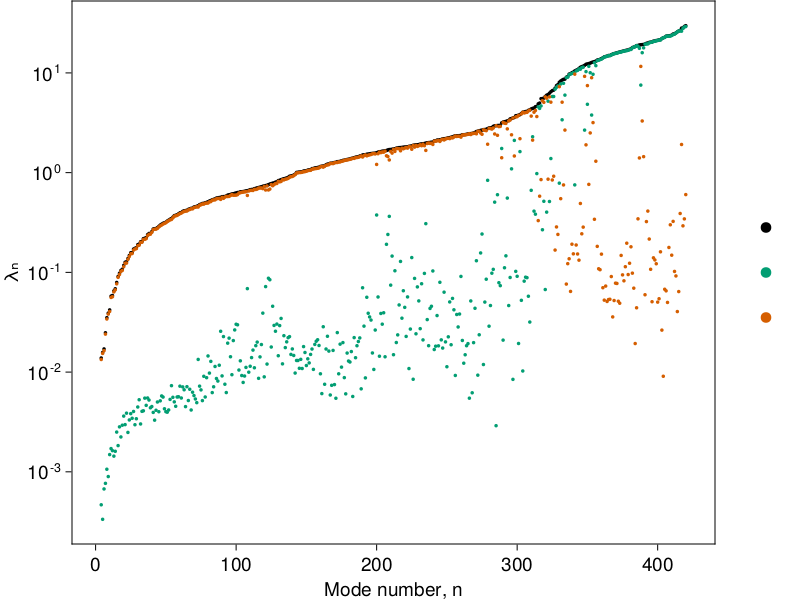

In [32]:
nv=LinRange(1, 2*nVerts, 2*nVerts)
nc=LinRange(2*nVerts-2*nCells+1, 2*nVerts, 2*nCells)
fig = Figure()
set_theme!(figure_padding=5, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
ax=Axis(fig[1, 1], xlabel="Mode number, n", ylabel="λₙ", yscale=log10)
hidedecorations!(ax, grid=true, ticks=false, label=false,ticklabels = false)
#vspan!(197.5, 396.5, color = (:grey, 0.3))
scatter!(ax,nv[4:end], ((abs.(evalH)))[4:end], color=:black,markersize=5, label=L"\lambda_n,\, \mathcal{H}")

#scatter!(ax,nv, (sort(abs.(evalLv))), color=ColorSchemes.seaborn_colorblind6[1],markersize=4, label=L"\lambda_n,\, \mathcal{L}_v^G")


scatter!(ax,nv[4:end], ((abs.(evmapLv)))[4:end], color=ColorSchemes.seaborn_colorblind6[2],markersize=5, label=L"\lambda_n,\, \mathcal{L}_v^G")
scatter!(ax,nv[4:end], ((abs.(evmapgX)))[4:end], color=ColorSchemes.seaborn_colorblind6[3],markersize=5, label=L"\lambda_n,\, \mathcal{H}")


elem_1 = [MarkerElement(color = :black, marker = :circle, markersize = 15)]

elem_2 = [MarkerElement(color = ColorSchemes.seaborn_colorblind6[2], marker = :circle, markersize = 15)]

elem_3 = [MarkerElement(color =ColorSchemes.seaborn_colorblind6[3], marker = :circle, markersize = 15)]

# # elem_4 = [MarkerElement(color =ColorSchemes.seaborn_colorblind6[3], marker = :circle, markersize = 12)]
Legend(fig[1, 2],
    [elem_1, elem_2, elem_3],
    ["","",""],
    patchsize = (35, 35), rowgap = 10, framevisible = false)
resize_to_layout!(fig)



#fig[1, 2] = Legend(fig, ax, framevisible = false)
save(datadir(f,"paper_figures","fig_2_no_legend_split_shade.pdf"),fig)
fig

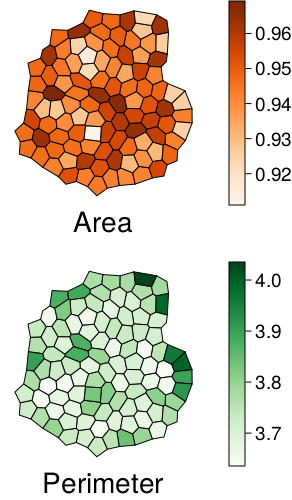

In [33]:
cellPolygons = makeCellPolygons(R,params,matrices)
Aevlims=(minimum(abs.(cellAreas[1:nCells])), maximum(abs.(cellAreas[1:nCells])))
Levlims=(minimum(abs.((cellPerimeters)[1:nCells])), maximum(abs.((cellPerimeters)[1:nCells])))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(1500,500))

a1=Axis(fig[1,1],aspect=DataAspect())
a2=Axis(fig[2,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)
hidedecorations!(a2)
hidespines!(a2)
for i=1:nCells
    poly!(a1,cellPolygons[i],color=cellAreas[i],colormap=ColorSchemes.Oranges,colorrange=Aevlims, strokecolor=(:black,1.0),strokewidth=1)
    poly!(a2,cellPolygons[i],color=cellPerimeters[i],colormap=ColorSchemes.Greens,colorrange=Levlims, strokecolor=(:black,1.0),strokewidth=1)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=Aevlims,colormap=ColorSchemes.Oranges,flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=Levlims,colormap=ColorSchemes.Greens,flipaxis=true)


Label(fig[1,1,Bottom()],"Area",fontsize =28, rotation=0)
Label(fig[2,1,Bottom()],"Perimeter",fontsize = 28, rotation=0)
#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
save(datadir(f,"paper_figures","Area_Perimeter.pdf"),fig)
fig

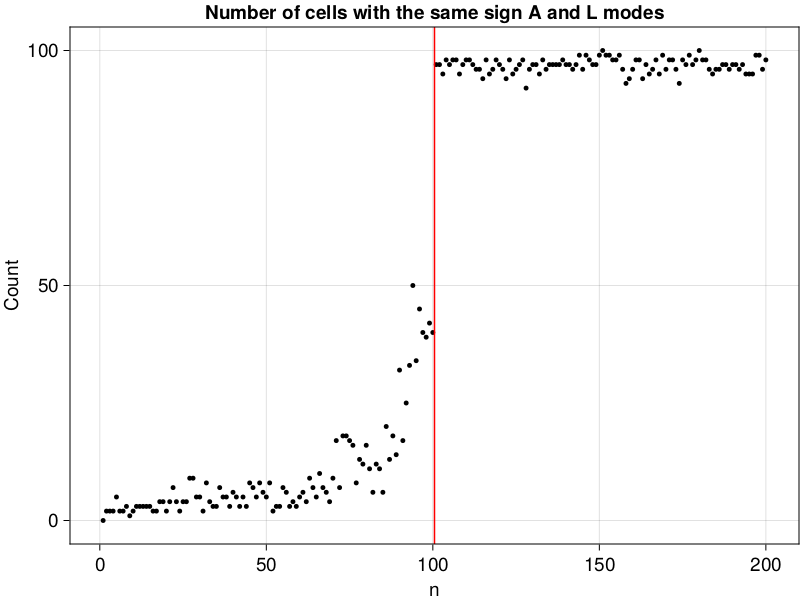

In [35]:
modeSign=zeros(2*nCells)
mode_mag_plus=zeros(2*nCells)
mode_mag_minus=zeros(2*nCells)
mode_magL_plus=zeros(2*nCells)
mode_magL_minus=zeros(2*nCells)
mode_magA_plus=zeros(2*nCells)
mode_magA_minus=zeros(2*nCells)
for n=1:2*nCells
    a=evecLc[1:nCells,n].*evecLc[nCells+1:end,n]
    bA=evecLc[1:nCells,n]
    bL=evecLc[nCells+1:end,n]
    modeSign[n]=length(a[a.>0])
    mode_mag_plus[n]=sum(a[a.>0])
    mode_mag_minus[n]=sum(a[a.<0])
    mode_magL_plus[n]=sum(bL[a.>0])
    mode_magL_minus[n]=sum(bL[a.<0])
    mode_magA_plus[n]=sum(bA[a.>0])
    mode_magA_minus[n]=sum(bA[a.<0])
end
n=LinRange(1, 2*nCells, 2*nCells)
fig = Figure()
ax=Axis(fig[1, 1], xlabel="n", ylabel="Count", title="Number of cells with the same sign A and L modes")

#scatter!(ax,n, mode_magL_plus, color=:red, label="Σ L modes, same sign", markersize=7)
scatter!(ax,n, modeSign, color=:black, label="Σ L modes, opposite", markersize=7)
# scatter!(ax,n, mode_magA_plus.+ mode_magL_plus, color=:red, label="Σ same sign", markersize=7)
# scatter!(ax,n, mode_magA_minus.+ mode_magL_minus, color=:blue, label="Σ opposite sign", markersize=7)

#vlines!(ax,2*nVerts-(2*nCells) +0.5, color=:red)
vlines!(ax,nCells+0.5, color=:red)
#fig[1, 2] = Legend(fig, ax, framevisible = false)
save(datadir(f,"eigenmodes","mode_sign.png"),fig)
fig

In [173]:
scene, layout = layoutscene(30, resolution = (1200, 900))

subgl_left = GridLayout()
subgl_left[1:2, 1:2] = [LAxis(scene) for i in 1:2, j in 1:2]

subgl_right = GridLayout()
subgl_right[1:3, 1] = [LAxis(scene) for i in 1:3]

layout[1, 1] = subgl_left
layout[1, 2] = subgl_right

UndefVarError: UndefVarError: `layoutscene` not defined

In [182]:
fig[row][col]

UndefVarError: UndefVarError: `row` not defined

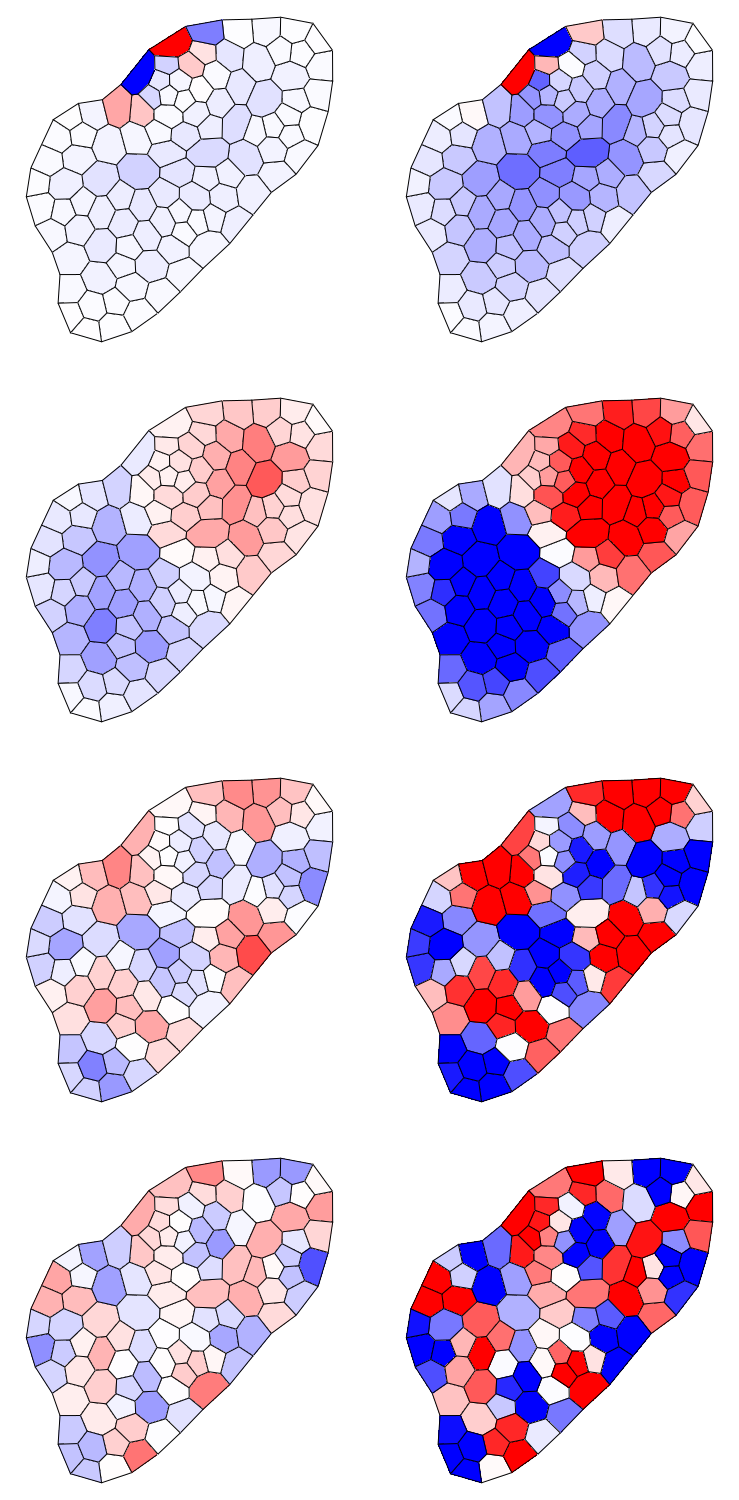

CairoMakie.Screen{IMAGE}


In [66]:
cellPolygons = makeCellPolygons(R,params,matrices)
n=200

ns=[[200, 199, 189, 179],[100, 99, 89, 79]]

fig = Figure(resolution=(1000,1500))
#fig[1,1]=GridLayout()

set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)

r1lims=(-maximum(abs.(Y[:,197:end])), maximum(abs.(Y[:,197:end])))
r2lims=(-maximum(abs.(Y[:,99:102])), maximum(abs.(Y[:,99:102])))

for row in 1:4
    col=2
    if col==1
        lims=(-0.2,0.2)
    elseif col==2
        lims=(-0.2,0.2)
    end

    a1=Axis(fig[row,col-1],aspect=DataAspect())
    a2=Axis(fig[row,col],aspect=DataAspect())
    hidedecorations!(a1)
    hidespines!(a1)
    hidedecorations!(a2)
    hidespines!(a2)
    for i=1:nCells
        poly!(a1,cellPolygons[i],color=[Y[1:nCells,ns[col][row]][i]],colormap=:bwr,colorrange=lims,highclip=:red, lowclip=:blue, strokecolor=(:black,1.0),strokewidth=1)
        poly!(a2,cellPolygons[i],color=[Y[nCells+1:2*nCells,ns[col][row]][i]],colormap=:bwr,colorrange=lims,highclip=:red, lowclip=:blue, strokecolor=(:black,1.0),strokewidth=1)
    end
    #Label(fig[2*row,col,Bottom()],L"\lambda_{"*string(2*nCells-(ns[row][col]-1))*"} = "*@sprintf("%.5E", sNF[ns[row][col]]^2),fontsize = 24)

    #hidedecorations!(ax22)
    #hidespines!(ax22)

    colsize!(fig.layout,col,Aspect(1,1.0))
    colsize!(fig.layout,col-1,Aspect(1,1.0))





    # if col==1
    #     Label(fig[2*row-1,1,Left()],"Area",fontsize =24, rotation=π/2)
    #     Label(fig[2*row,1,Left()],"Perimeter",fontsize = 24, rotation=π/2)
    # end
end

# Colorbar(fig[1:2,5],limits=(-0.25,0.25), highclip=:red, lowclip=:blue,colormap=:bwr,flipaxis=true)
# Colorbar(fig[3:4,5],limits=(-0.5,0.5),colormap=:bwr,flipaxis=true, highclip=:red, lowclip=:blue)
# Colorbar(fig[5:6,5],limits=(-1,1),colormap=:bwr,flipaxis=true, highclip=:red, lowclip=:blue)


# Label(fig[1,1,Top()],"Area",fontsize = 18)
# Label(fig[1,2,Top()],"Perimeter",fontsize = 18)

# Label(fig[1,1,Left()],"1",fontsize = 18)
# Label(fig[2,1,Left()],"2",fontsize = 18)
# Label(fig[3,1,Left()],"10",fontsize = 18)
# Label(fig[4,1,Left()],"20",fontsize = 18)

# Label(fig[3,1,Top()],"λ₁₀₁  = "*formatted(sNF[ns[2][1]]^2, :SCI, ndigits=3),fontsize = 18)
# Label(fig[3,2,Top()],"λ₁₀₂ = "*formatted(sNF[ns[2][2]]^2, :SCI, ndigits=3),fontsize = 18)
# Label(fig[3,3,Top()],"λ₁₁₀ = "*formatted(sNF[ns[2][3]]^2, :SCI, ndigits=3),fontsize = 18)
# Label(fig[3,4,Top()],"λ₁₂₀ = "*formatted(sNF[ns[2][4]]^2, :SCI, ndigits=3),fontsize = 18)


#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"paper_figures","eigenmodes_Y.png"),fig)

    display(fig)
#end


In [ ]:
cellPolygons = makeCellPolygons(R,params,matrices)
n=200

ns=[[200, 199, 198, 197],[102, 101, 100, 99], [4,3,2,1]]

fig = Figure(resolution=(1000,1500))
#fig[1,1]=GridLayout()

set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)

r1lims=(-maximum(abs.(Y[:,197:end])), maximum(abs.(Y[:,197:end])))
r2lims=(-maximum(abs.(Y[:,99:102])), maximum(abs.(Y[:,99:102])))
r3lims=(-maximum(abs.(Y[:,1:4])), maximum(abs.(Y[:,1:4])))

for row in 1:5,  col in 1:2

    if row==1
        lims=(-0.2,0.2)
    elseif row==2
        lims=(-0.4,0.4)
    else
        lims=(-0.75,0.75)
    end

    a1=Axis(fig[2*row-1,col],aspect=DataAspect())
    a2=Axis(fig[2*row,col],aspect=DataAspect())
    hidedecorations!(a1)
    hidespines!(a1)
    hidedecorations!(a2)
    hidespines!(a2)
    for i=1:nCells
        poly!(a1,cellPolygons[i],color=[Y[1:nCells,ns[row][col]][i]],colormap=:bwr,colorrange=lims,highclip=:red, lowclip=:blue, strokecolor=(:black,1.0),strokewidth=1)
        poly!(a2,cellPolygons[i],color=[Y[nCells+1:2*nCells,ns[row][col]][i]],colormap=:bwr,colorrange=lims,highclip=:red, lowclip=:blue, strokecolor=(:black,1.0),strokewidth=1)
    end
    #Label(fig[2*row,col,Bottom()],L"\lambda_{"*string(2*nCells-(ns[row][col]-1))*"} = "*@sprintf("%.5E", sNF[ns[row][col]]^2),fontsize = 24)

    #hidedecorations!(ax22)
    #hidespines!(ax22)

    colsize!(fig.layout,col,Aspect(1,1.0))



    if col==1
        Label(fig[2*row-1,1,Left()],"Area",fontsize =24, rotation=π/2)
        Label(fig[2*row,1,Left()],"Perimeter",fontsize = 24, rotation=π/2)
    end
end

# Colorbar(fig[1:2,5],limits=(-0.25,0.25), highclip=:red, lowclip=:blue,colormap=:bwr,flipaxis=true)
# Colorbar(fig[3:4,5],limits=(-0.5,0.5),colormap=:bwr,flipaxis=true, highclip=:red, lowclip=:blue)
# Colorbar(fig[5:6,5],limits=(-1,1),colormap=:bwr,flipaxis=true, highclip=:red, lowclip=:blue)



Label(fig[1,1,Top()],"λ₁ = "*formatted(sNF[ns[1][1]]^2, :SCI, ndigits=3),fontsize = 18)
Label(fig[1,2,Top()],"λ₂ = "*formatted(sNF[ns[1][2]]^2, :SCI, ndigits=3),fontsize = 18)
Label(fig[1,3,Top()],"λ₃ = "*formatted(sNF[ns[1][3]]^2, :SCI, ndigits=3),fontsize = 18)
Label(fig[1,4,Top()],"λ₄= "*formatted(sNF[ns[1][4]]^2, :SCI, ndigits=3),fontsize = 18)

Label(fig[3,1,Top()],"λ₉₉ = "*formatted(sNF[ns[2][1]]^2, :SCI, ndigits=3),fontsize = 18)
Label(fig[3,2,Top()],"λ₁₀₀ = "*formatted(sNF[ns[2][2]]^2, :SCI, ndigits=3),fontsize = 18)
Label(fig[3,3,Top()],"λ₁₀₁ = "*formatted(sNF[ns[2][3]]^2, :SCI, ndigits=3),fontsize = 18)
Label(fig[3,4,Top()],"λ₁₀₂ = "*formatted(sNF[ns[2][4]]^2, :SCI, ndigits=3),fontsize = 18)

Label(fig[5,1,Top()],"λ₁₉₇ = "*formatted(sNF[ns[3][1]]^2, :SCI, ndigits=3),fontsize = 18)
Label(fig[5,2,Top()],"λ₁₉₈ = "*formatted(sNF[ns[3][2]]^2, :SCI, ndigits=3),fontsize = 18)
Label(fig[5,3,Top()],"λ₁₉₉ = "*formatted(sNF[ns[3][3]]^2, :SCI, ndigits=3),fontsize = 18)
Label(fig[5,4,Top()],"λ₂₀₀ = "*formatted(sNF[ns[3][4]]^2, :SCI, ndigits=3),fontsize = 18)


#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
save(datadir(f,"paper_figures","eigenmodes_Y.png"),fig)

    display(fig)
#end


┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


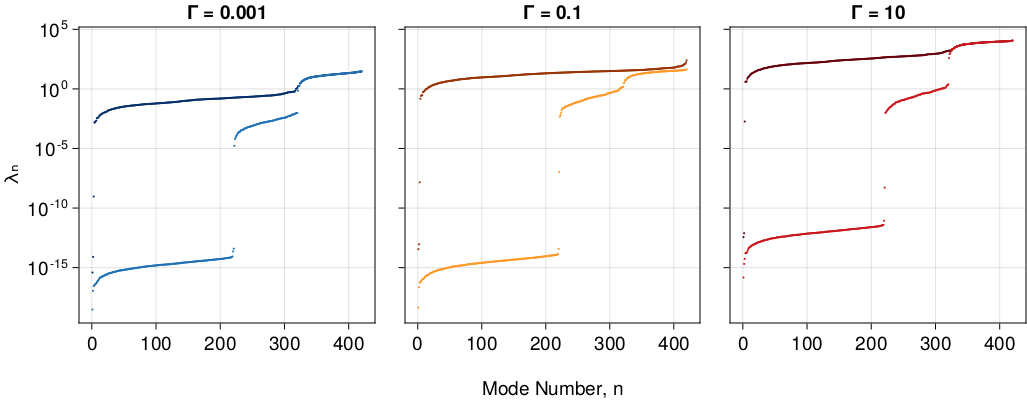

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


CairoMakie.Screen{IMAGE}


In [143]:
folders=Glob.glob("relax_100_cells/pointy/*L₀=*","C:\\Users\\v35431nc\\Documents\\VM_code\\VertexModel\\data\\sims" )
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(1500,400))

a1=Axis(fig[1,1], ylabel="λₙ",title="Γ = 0.001", yscale=log10)
a2=Axis(fig[1,2],yticklabelsvisible=false, title="Γ = 0.1", yscale=log10)
a3=Axis(fig[1,3],yticklabelsvisible=false, title="Γ = 10",yscale=log10)


linkyaxes!(a1,a2,a3)
linkxaxes!(a1,a2,a3)


axes=[a1,a2,a3]
cmaps=[ColorSchemes.Blues_9,ColorSchemes.YlOrBr_5, ColorSchemes.Reds_9]
m=1
for i=1:2:length(folders)
    evH=readdlm(datadir(folders[i], "eigenmodes","HE_eigenvalues.csv"))[:,1]
    evLv=readdlm(datadir(folders[i], "eigenmodes","LvE_eigenvalues.csv"))[:,1]
    @unpack R, matrices, params = load(datadir(folders[i],"frameData/systemDataFinal.jld2"))
    @unpack nCells,nVerts, γ, L₀ = params
    n=LinRange(1, length(evH), length(evH))
    scatter!(axes[m],n, (sort(abs.(evH))),color=cmaps[m][end],markersize=3,label="Γ = "*string(γ))
    scatter!(axes[m],n, (sort(abs.(evLv))),color=cmaps[m][end-2],markersize=3,label="Γ = "*string(γ))
    m+=1
end
#Label(fig[2,1,Bottom()],"λ_"*string(2*nVerts-2*nCells+n)*" = "*@sprintf("%.5E", evalH[2*nVerts-2*nCells+n]),fontsize = 32)

# #hidedecorations!(ax22)
# #hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))
colsize!(fig.layout,2,Aspect(1,1.0))
colsize!(fig.layout,3,Aspect(1,1.0))


xlabel = Label(fig[2, 1:3], "Mode Number, n", rotation = 0)

# Colorbar(fig[1,2],limits=colorrange=Aevlims,colormap=:bwr,flipaxis=true)
# Colorbar(fig[2,2],limits=colorrange=Levlims,colormap=:bwr,flipaxis=true)


# Label(fig[1,1,Left()],string(L"Area"),fontsize = 32, rotation=π/2)
# Label(fig[2,1,Left()],string(L"Perimeter"),fontsize = 32, rotation)
# #Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
save(datadir(f,"paper_figures","Vary_gamma_Lv_H_no_legend.png"),fig)

display(fig)

In [154]:
["Γ = "*string(Γ[x]) for x in 1:5]

5-element Vector{String}:
 "Γ = 0.001"
 "Γ = 0.01"
 "Γ = 0.1"
 "Γ = 1.0"
 "Γ = 10.0"

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.

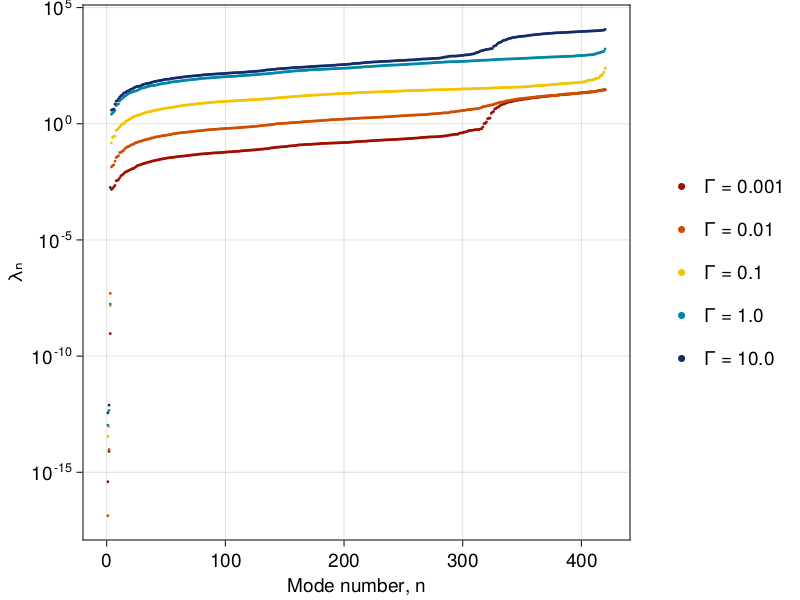

In [159]:
Γ=[]
fig = Figure()
set_theme!(figure_padding=5, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
ax=Axis(fig[1, 1], xlabel="Mode number, n", ylabel="λₙ", title=" ", yscale=log10)
m=1
for f in folders
    evH=readdlm(datadir(f, "eigenmodes","HE_eigenvalues.csv"))[:,1]
    @unpack R, matrices, params = load(datadir(f,"frameData/systemDataFinal.jld2"))
    @unpack nCells,nVerts, γ, L₀ = params
    n=LinRange(1, length(evH), length(evH))
    scatter!(ax,n[1:end], (sort(abs.(evH)))[1:end],color=ColorSchemes.Johnson[m],markersize=4, label="Γ = "*string(γ))
    append!(Γ,γ)
    #vlines!(ax,2*nVerts+1-((2*nCells)-1), color=:red)
   m+=1
end
#ylims!((10^(-5)), 10^5)

#fig[1, 2] = Legend(fig, ax, framevisible = false)
# elem_1 = [MarkerElement(color = Makie.wong_colors()[1], marker = :circle, markersize = 10)]

# elem_2 = [MarkerElement(color = Makie.wong_colors()[2], marker = :circle, markersize = 10)]

elem=[MarkerElement(color = ColorSchemes.Johnson[x], marker = :circle, markersize = 10) for x in 1:5]
Legend(fig[1, 2],
    elem,
    ["Γ = "*string(Γ[x]) for x in 1:5],
    patchsize = (35, 35), rowgap = 8, framevisible=false)
resize_to_layout!(fig)

save(datadir(f,"paper_figures","compare_spectra_H_gamma_non_zero.png"),fig)

fig